In [ ]:
# !pip install -U onnxruntime-gpu==1.12.1

In [1]:
import cv2
import glob
import torch
import numpy as np
from PIL import Image
from super_gradients.training import models

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = ['product']
CLASSES += [str(i) for i in range(80 - len(CLASSES))]

model = models.get(
    "yolo_nas_s",
    num_classes=len(CLASSES),
    checkpoint_path=f"./weights/SKU110K/average_model.pth"
)

[2023-08-01 11:54:58] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/nitin/sg_logs/console.log


2023-08-01 11:54:58.941009: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 11:54:58.962953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 11:54:59.282262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2023-08-01 11:54:59] INFO - utils.py - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-08-01 11:54:59] INFO - utils.py - NumExpr defaulting to 8 threads.
/home/nitin/anaconda3/lib/python3.10/site-packages/

In [2]:
models.convert_to_onnx(model=model, input_shape=(3,640,640), out_path="./weights/SKU110K/average_model.onnx")

[2023-08-01 11:55:04] WARNING - conversion.py - input_shape is deprecated and will be removed in the next major release.Use the convert_to_onnx(..., prep_model_for_conversion_kwargs(input_size=(1, 3, 640, 640))) instead


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'./weights/SKU110K/average_model.onnx'

In [3]:
from yolo_nas_onnx.models import load_net
from yolo_nas_onnx.processing import Preprocessing, Postprocessing
from yolo_nas_onnx.draw import draw_box
from yolo_nas_onnx.utils import Labels

In [4]:
def detect(net, source, pre_process, post_process, labels):
    net_input = source.copy()  # copy source array
    input_, prep_meta = pre_process(net_input)  # run preprocess
    outputs = net.forward(input_)  # forward

    boxes, scores, classes = post_process(outputs, prep_meta)  # postprocess output
    selected = cv2.dnn.NMSBoxes(
        boxes, scores, post_process.score_thres, post_process.iou_thres
    )  # run nms to filter boxes

    for i in selected:  # loop through selected idx
        box = boxes[i, :].astype(np.int32).flatten()  # get box
        score = float(scores[i]) * 100  # percentage score
        label, color = labels(classes[i], use_bgr=True)  # get label and color class_id

        draw_box(source, box, label, score, color)  # draw boxes
    return source  # Image array after draw process

use_gpu = True
use_opencv_dnn_runtime = False
model_path = "./weights/SKU110K/average_model.onnx"

net = load_net(model_path, use_gpu, use_opencv_dnn_runtime)
net.assert_input_shape([1,3,640,640])
net.warmup()

2023-08-01 11:55:31.348321644 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:566 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/reference/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [5]:
prep_steps = [
    {"DetLongMaxRescale": None},
    {"BotRightPad": {"pad_value": 114}}
]

iou_thres = 0.65
score_thres = 0.5
labels = ["0"]

_, _, input_height, input_width = net.input_shape  # get input height and width [b, c, h, w]

pre_process = Preprocessing(
    prep_steps, (input_height, input_width)
)

post_process = Postprocessing(
    prep_steps,
    iou_thres,
    score_thres,
)

labels = Labels(labels)

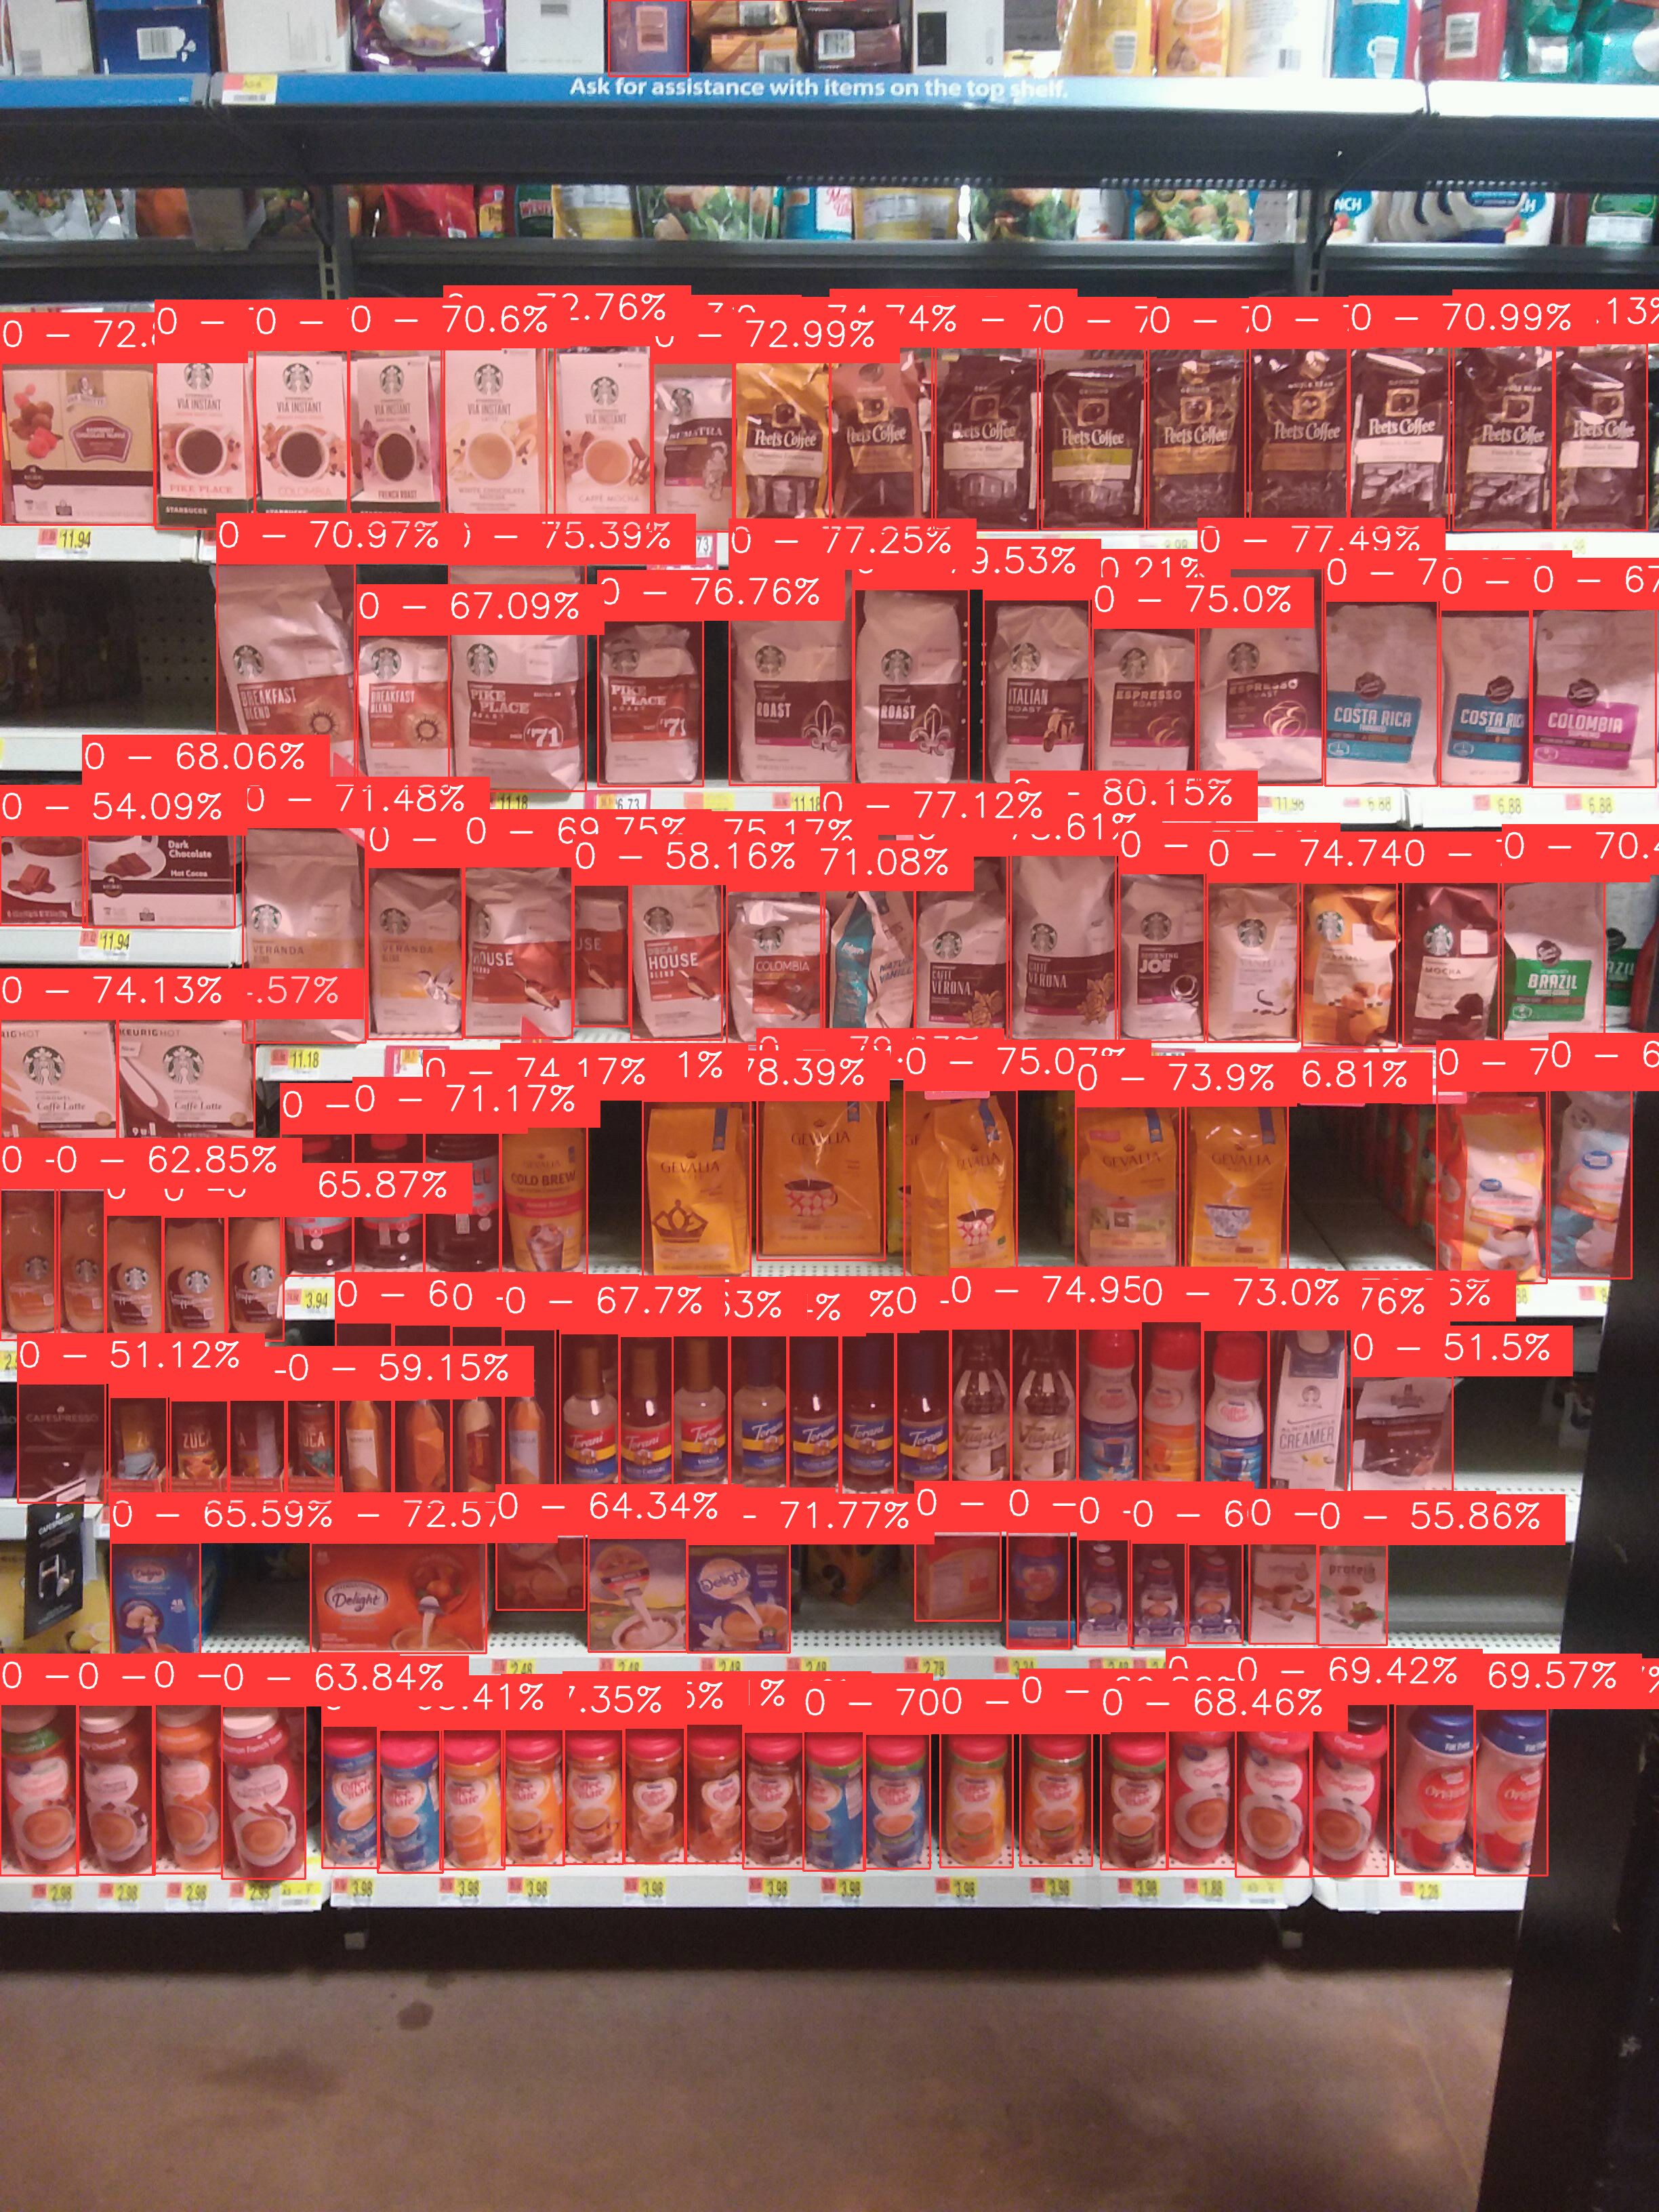

In [9]:
import cv2
import numpy as np
from PIL import Image

img = cv2.imread("./SKU110K_fixed/images/test/test_0.jpg")
img = detect(net, img, pre_process, post_process, labels)

Image.fromarray(img[:,:,::-1])